In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

#!apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
#!pip install cyipopt
# import cyipopt
# from cyipopt import minimize_ipopt

#%pip install pyomo
import pyomo
#from pyomo.environ import ConcreteModel, Set, RangeSet, Param, Var, Objective, Constraint, NonNegativeIntegers, Binary, minimize, value
from pyomo.environ import *
from pyomo.opt import SolverFactory


Data generation

In [360]:
#Define the number of elements in each set I, J, K
i_num = 5
k_num = 1
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [361]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

I.index = I['Point number']


for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

J.index = J['Point number']
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,996.0,1100.0
j1,j1,3033.0,4847.0
j2,j2,35.0,3683.0
j3,j3,848.0,4160.0
j4,j4,2136.0,3936.0
...,...,...,...
i0,i0,4219.0,1745.0
i1,i1,2750.0,1706.0
i2,i2,512.0,2346.0


In [362]:
# ### PASSAU  ###

# #Define sets of I, J, K, where J contains I and K for Passau

# #Define the number of elements in each set I, J, K

# degree_to_m = 111111

# #Define empty data frames
# I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

# column_types = {
#     'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
#     'Latitude': 'float',
#     'Longitude': 'float',
#     'Address': 'str'
#     # Add more columns and their data types as needed
# }

# doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

# doctors

# for i in range(len(doctors['Latitude'])):
#     I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
#     I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
#     I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

# I_coordinates.index = I_coordinates['Point number']

# I = I_coordinates * degree_to_m
# I['Point number'] = I_coordinates['Point number']


# labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types)
# labs

# for k in range(len(labs['Latitude'])):
#     K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
#     K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
#     K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

# K_coordinates.index = K_coordinates['Point number']

# K = K_coordinates * degree_to_m
# K['Point number'] = K_coordinates['Point number']


# #Define range of coordinates

# combined_coordinates = pd.concat([I_coordinates, K_coordinates])

# min_latitude = combined_coordinates['Latitude'].min()
# max_latitude = combined_coordinates['Latitude'].max()
# min_longitude = combined_coordinates['Longitude'].min()
# max_longitude = combined_coordinates['Longitude'].max()

# grid_spacing = 0.0018

# # Create grid points
# grid_points = []
# for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
#     for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
#         grid_points.append((round(lat, 6), round(lon, 6)))

# J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
# J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

# J_coordinates.index = J_coordinates['Point number']
# J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J

# river = ['j972', 'j973', 'j918', 'j919', 'j920', 'j866', 'j867', 'j813', 'j814',
# 'j815', 'j760', 'j761', 'j762', 'j707', 'j708', 'j709', 'j710', 'j654',
# 'j655', 'j656', 'j657', 'j658', 'j606', 'j610', 'j611', 'j612', 'j613', 'j614',
# 'j615', 'j616', 'j620', 'j621', 'j622', 'j623', 'j624', 'j625', 'j682', 'j683',
# 'j684','j685','j686', 'j635', 'j636', 'j637', 'j638', 'j585', 'j586', 'j587',
# 'j588', 'j589', 'j590', 'j591', 'j592','j593', 'j531', 'j530', 'j529', 'j528',
# 'j527', 'j22', 'j23', 'j77', 'j132', 'j133', 'j134', 'j189', 'j190', 'j244',
# 'j245', 'j300', 'j301', 'j356', 'j411', 'j412', 'j467', 'j523', 'j524', 'j525', 'j526',

# 'j246', 'j247', 'j191', 'j192', 'j193', 'j194', 'j135', 'j136', 'j137', 'j138', 'j139',
# 'j140', 'j141', 'j78', 'j79', 'j80', 'j81', 'j82', 'j83', 'j84', 'j85', 'j86', 'j87', 'j88',
# 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36',
#  'j261', 'j262', 'j263', 'j264', 'j266', 'j267', 'j268', 'j269', 'j206', 'j207', 'j208',
# 'j209', 'j210', 'j211', 'j212', 'j213', 'j214', 'j215', 'j153', 'j154', 'j155', 'j156',
# 'j157', 'j158', 'j159', 'j160', 'j161', 'j98', 'j99', 'j100', 'j101', 'j102', 'j103',
# 'j104', 'j105', 'j106', 'j107', 'j43', 'j44', 'j45', 'j46', 'j47', 'j48', 'j49', 'j50',
# 'j51', 'j52', 'j53'
#  ]

# J_coordinates = J_coordinates.drop(index = river) #excluding locations on the river

# J = J_coordinates * degree_to_m
# J['Point number'] = J_coordinates['Point number']
# J


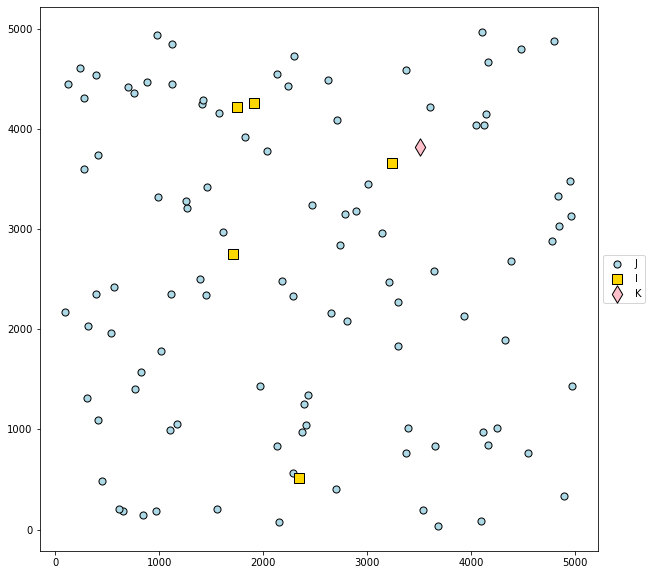

In [363]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [364]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib



# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Making Passau polygon

# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

# passau_poly = shapely.wkt.loads(polygon_str)
# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# folium.GeoJson(passau_gdf).add_to(passau_map)


# # Assuming I_coordinates is your DataFrame with doctor coordinates
# geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']],
#                   icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1),
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)

# geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_labs.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']],
#                   icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1,
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)

# geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_bases.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.CircleMarker([row['Latitude'], row['Longitude']],
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


# #Custom legend

# legend_html = '''
#      <div style="position: fixed;
#                  bottom: 100px; right: 100px; width: 300px; height: 150px;
#                  border:2px solid grey; z-index:9999; font-size:16px;
#                  background-color:white; opacity: 0.9;
#                  ">
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:orange"></i> Doctors &nbsp; <br>
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:red"></i> Laboratories &nbsp; <br>
#      &nbsp; <svg height="40" width="40">
#           <circle cx="20" cy="20" r="18" fill="none" stroke="#3388FF" stroke-width="2" />
#         </svg> Bases &nbsp;
#       </div>
#      '''



# # Add the legend to the map
# passau_map.get_root().html.add_child(folium.Element(legend_html))

# passau_map

In [365]:
#Define constants

B = 91800 #battery load: meters of travel
S = 5100 #meters of service time
W = 2500 #max grams of weight

p = 0.95

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920

gamma = 0.0045 / 1000 # variable cost in euro per m

q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 60
hardlimit = 10000

In [366]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

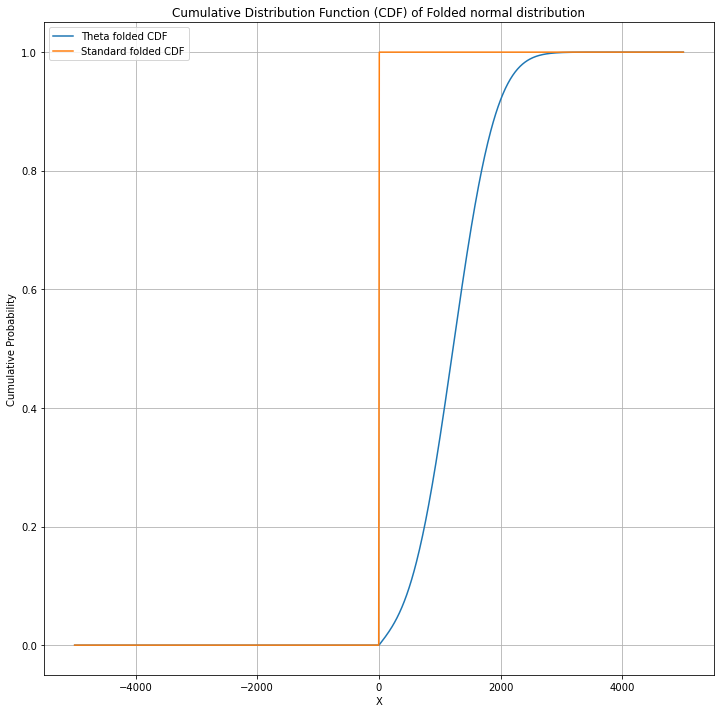

In [367]:
mean = {i : random.uniform(500, 3000) for i in I.index}
std_dev = {i : random.uniform(100, 800) for i in I.index}

#Define random variable

theta_ran_i = {}
for i in list(I.index):
    theta_ran_i[i] = foldnorm(c=mean[i]/std_dev[i], scale=std_dev[i]) 
    
#Define deterministic theta
theta_det = {}
for i in I.index:
    theta_det[i] = theta_ran_i[i].rvs(1)[0]

x = np.linspace(-5000, 5000, 1000)  # Generate 1000 points from 0 to 5
cdf = theta_ran_i['i3'].cdf(x)
cdf_foldnorm = foldnorm.cdf(x, c=0, scale=1)
cdf_norm = norm.cdf(x, loc=0, scale=1)
plt.figure(figsize=(12, 12))
plt.plot(x, cdf, label='Theta folded CDF')
plt.plot(x, cdf_foldnorm, label='Standard folded CDF')
#plt.plot(x, cdf_norm, label='Standard CDF')
plt.title('Cumulative Distribution Function (CDF) of Folded normal distribution')
plt.xlabel('X')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

In [403]:
# Define the parameters for the folded normal distribution

step = 0.005
foldnorm_std_values = np.arange(0, 1, step).tolist()
tx_values = np.delete(foldnorm.ppf(x, c=0, scale=1), -1).tolist()


[0.0,
 0.005,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 0.05,
 0.055,
 0.06,
 0.065,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1,
 0.105,
 0.11,
 0.115,
 0.12,
 0.125,
 0.13,
 0.135,
 0.14,
 0.145,
 0.15,
 0.155,
 0.16,
 0.165,
 0.17,
 0.17500000000000002,
 0.18,
 0.185,
 0.19,
 0.195,
 0.2,
 0.20500000000000002,
 0.21,
 0.215,
 0.22,
 0.225,
 0.23,
 0.23500000000000001,
 0.24,
 0.245,
 0.25,
 0.255,
 0.26,
 0.265,
 0.27,
 0.275,
 0.28,
 0.28500000000000003,
 0.29,
 0.295,
 0.3,
 0.305,
 0.31,
 0.315,
 0.32,
 0.325,
 0.33,
 0.335,
 0.34,
 0.34500000000000003,
 0.35000000000000003,
 0.355,
 0.36,
 0.365,
 0.37,
 0.375,
 0.38,
 0.385,
 0.39,
 0.395,
 0.4,
 0.405,
 0.41000000000000003,
 0.41500000000000004,
 0.42,
 0.425,
 0.43,
 0.435,
 0.44,
 0.445,
 0.45,
 0.455,
 0.46,
 0.465,
 0.47000000000000003,
 0.47500000000000003,
 0.48,
 0.485,
 0.49,
 0.495,
 0.5,
 0.505,
 0.51,
 0.515,
 0.52,
 0.525,
 0.53,
 0.535,
 0.54,
 0.545,
 0.55,
 0.555,
 0.56,
 0.5650000000000

In [369]:
precision = 100

# Step 2: Compute the empirical CDF

cdf_values = np.arange(p, 1, 0.005)
cdf_values

array([0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 ,
       0.995, 1.   ])

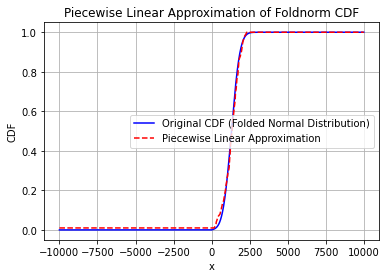

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

In [ ]:
plt.plot(x, original_cdf, label='Original CDF (Folded Normal Distribution)', color='blue')
plt.plot(x, approx_cdf, label='Piecewise Linear Approximation', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.title('Piecewise Linear Approximation of Foldnorm CDF')
plt.grid(True)
plt.show()

approx_cdf

Deterministic model DM

In [ ]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

dist_KJ


{('k0', 'j0'): 3716.361258004932,
 ('k0', 'j1'): 1553.9732944938276,
 ('k0', 'j2'): 3793.946362298761,
 ('k0', 'j3'): 3047.134555611222,
 ('k0', 'j4'): 1741.894658123734,
 ('k0', 'j5'): 2077.54302001186,
 ('k0', 'j6'): 707.9562133352599,
 ('k0', 'j7'): 1660.9843467052904,
 ('k0', 'j8'): 579.9284438618268,
 ('k0', 'j9'): 1894.3687602998525,
 ('k0', 'j10'): 1385.3187358871603,
 ('k0', 'j11'): 2992.8984279457263,
 ('k0', 'j12'): 3222.3376607674127,
 ('k0', 'j13'): 4524.8364611331535,
 ('k0', 'j14'): 2139.4525000569656,
 ('k0', 'j15'): 2143.815523779973,
 ('k0', 'j16'): 2707.0740662198364,
 ('k0', 'j17'): 1108.600018040772,
 ('k0', 'j18'): 2002.4677275801475,
 ('k0', 'j19'): 4114.173671589472,
 ('k0', 'j20'): 3265.5183355785953,
 ('k0', 'j21'): 3199.825776507215,
 ('k0', 'j22'): 2570.4958665596023,
 ('k0', 'j23'): 3099.1116469078684,
 ('k0', 'j24'): 3626.324309821172,
 ('k0', 'j25'): 2709.385539195188,
 ('k0', 'j26'): 3262.510076612791,
 ('k0', 'j27'): 1685.567560200421,
 ('k0', 'j28'): 62

In [ ]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")

        print("\n")


In [ ]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


In [ ]:
def SolutionGraph(I, K, J, model):

        axs, fig = plt.subplots(1, 1, figsize = (20, 20))

        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))

        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))

        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        #(I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                         #color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))


In [ ]:
# def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):

#         with open('Polygon Passau.txt', 'r') as file:
#         # Read the contents of the file into a string
#                 polygon_str = file.read()

#         # Making Passau polygon
#         passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
#         passau_poly = shapely.wkt.loads(polygon_str)
#         passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
#         folium.GeoJson(passau_gdf).add_to(passau_map)

#         # Assuming I_coordinates is your DataFrame with doctor coordinates
#         geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

#         indices_xi = []
#         indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
#         indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])


#         i = 0
#         for v in model.getVars():
#                 if v.x > 0:
#                         if v.varName.startswith('x_ikj'):
#                                 indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
#                                 indices_x.loc[i, 'I'] = str(indices_xi[0])
#                                 indices_x.loc[i, 'J'] = str(indices_xi[2])
#                                 indices_x.loc[i, 'Number of drones'] = int(v.x)
#                                 i += 1

#                         else:
#                                 y_name = v.varName[4:-1]
#                                 indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
#                                 indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
#                                 indices_y.loc[str(y_name), 'Location name'] = str(y_name)
#                                 #
#                                 # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
#                                 #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)

#         geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")



#         for idx, row in geo_doctors.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                         icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1),
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)



#         geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

#         for idx, row in geo_labs.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                                 icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1,
#                                 popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


#         for idx, row in geo_solution_y.iterrows():
#                 coordinates_label = f"Loc: {row['Location name']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']],
#                         icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1),
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


#         for idx, row in indices_x.iterrows():
#                 point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
#                 point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
#                 folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']),
#                                         (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)

#                 label = str(row['Number of drones'])
#                 div_icon_style = "background-color: white; border-radius: 50%; padding: 5px;"

#                 circle_size = 20
#                 folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, (point_i['Longitude'] + point_j['Longitude']) / 2], icon=folium.DivIcon(
#                 html=f"<div style='{div_icon_style}; width: {circle_size}px; height: {circle_size}px;'><div style='font-size: 10pt; color: blue;'>{label}</div></div>")).add_to(passau_map)


#         return passau_map


In [ ]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))

L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))

P

[('i0', 'k0'), ('i1', 'k0'), ('i2', 'k0'), ('i3', 'k0'), ('i4', 'k0')]

In [ ]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []

N_i_final = {key : val for key, val in N_i.items() if val != []}

I_feas = list(N_i_final.keys())

In [ ]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []

O_j_final = {key : val for key, val in O_j.items() if val != []}

J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'k0',
 'i0',
 'i1',
 'i2',
 'i3',
 'i4']

Deterministic model (DM)

In [ ]:

def AddBasisGurobi(model, I, J, K, L, N_i_final, theta_det, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit):

    #Adding basic variables x_ikj and y_j
    x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
    y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


    #Adding constraints except for demand covering
    model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
    model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
    model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
    model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

    #Set objective
    model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

    #Set parameter TimeLimit
    model.setParam('TimeLimit', hardlimit)

    return x_ikj, y_j


In [ ]:

model_DM = gp.Model('DM')

x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, theta_det, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

model_DM.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1172 rows, 636 columns and 2227 nonzeros
Model fingerprint: 0xef89cb31
Variable types: 0 continuous, 636 integer (106 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Found heuristic solution: objective 984320.17467
Presolve removed 1172 rows and 636 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 172320 984320 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.723201161202e+05, best bo

In [ ]:
ListSolution(model_DM)

Number of solutions found: 2
0
172320 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,k0] 1
x_ikj[i2,k0,k0] 2
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,k0] 1
y_j[k0] 1


1
984320 
x_ikj[i0,k0,k0] 1
x_ikj[i1,k0,k0] 1
x_ikj[i2,k0,k0] 2
x_ikj[i3,k0,k0] 1
x_ikj[i4,k0,k0] 1
y_j[k0] 1






In [ ]:
SolutionSummary(model_DM)

(    i  Number of drones
 0  i0                 1
 1  i1                 1
 2  i2                 2
 3  i3                 1
 4  i4                 1,
     j  Number of drones
 0  k0                 6,
     k  Number of drones
 0  k0                 6,
 'Total number of drones: 6',
 'Total number of locations: 1')

In [ ]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_DM)

In [ ]:
#SolutionGraph(I, K, J, model_DM)

In [ ]:
def ApproximationCDF(z):
    
    # pi = 3.141592653589793
    # a = 1/(sqrt(2*pi))
    # b = exp(-z**2/2)
    # y = 0.455428 - 0.0329012 * z - 0.00681111 * z**2 + 0.00300713 * z**3 - 0.00039299 * z**4 - 0.00004552 * z**5 + 0.00002614 * z**6 + 0.00000412 * z**7 + 0.00000025 * z**8
    # c = z + sqrt(2/pi) * exp(-y*z)
    # result = 1-a*(b/c)
    
    result = 2 * z
    
    return result

ApproximationCDF(1)

2

In [ ]:
theta_ran_i['i0'].cdf(1500)



0.6711850709807894

In [ ]:
model_PM = gp.Model('PM')

x_ikj, y_j = AddBasisGurobi(model_PM, I, J, K, L, N_i_final, theta_det, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                            alpha, beta, gamma, hardlimit)

#Add demand constraints
model_PM.addConstrs((ApproximationCDF(gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i])) >= p for i in I_feas), name = 'Demand')

model_PM.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1172 rows, 636 columns and 2227 nonzeros
Model fingerprint: 0x9d8c6f03
Variable types: 0 continuous, 636 integer (106 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 968420.14136
Presolve removed 1172 rows and 636 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 156420 968420 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.564200845164e+05, best bo

In [ ]:
# model_PM = ConcreteModel()

# # Sets
# model_PM.I = Set(initialize=I.index)
# model_PM.J = Set(initialize=J.index)
# model_PM.K = Set(initialize=K.index)
# model_PM.L = Set(initialize=L)
# model_PM.I_feas = Set(initialize=I_feas)
# model_PM.KJ_feas = Set(initialize=KJ_feas)
# model_PM.J_feas = Set(initialize=J_feas)

# # Parameters
# model_PM.dist_JI = Param(model_PM.J, model_PM.I, initialize=dist_JI)
# model_PM.dist_IK = Param(model_PM.I, model_PM.K, initialize=dist_IK)
# model_PM.dist_KJ = Param(model_PM.K, model_PM.J, initialize=dist_KJ)
# model_PM.B = Param(initialize=B)
# model_PM.S = Param(initialize=S)
# model_PM.alpha = Param(initialize=alpha)
# model_PM.beta = Param(model_PM.J, initialize=beta)
# model_PM.gamma = Param(initialize=gamma)
# model_PM.W = Param(initialize=W)
# model_PM.p = Param(initialize=W)
# #model_PM.x_ikj = Param(model_PM.I, model_PM.K, model_PM.J, initialize=1, mutable=True)

# #Dictionaries

# model_PM.N_i_final_index = Set(initialize=N_i_final.keys())
# model_PM.N_i_final = Set(model_PM.N_i_final_index, initialize=lambda model, i: N_i_final[i])

# model_PM.O_j_final_index = Set(initialize=O_j_final.keys())
# model_PM.O_j_final = Set(model_PM.O_j_final_index, initialize=lambda model, j: O_j_final[j])

# model_PM.q_j_index = Set(initialize=q_j.keys())
# model_PM.q_j = Param(model_PM.q_j_index, initialize=lambda model, j: q_j[j])

# model_PM.theta_det = Param(model_PM.I, initialize=theta_det)

# # Variables
# model_PM.x_ikj = Var(model_PM.I_feas, model_PM.L, within=NonNegativeIntegers, bounds=(0, max(q_j.values())), initialize=0)
# model_PM.y_j = Var(model_PM.J_feas, within=Binary, initialize=0)

# model_PM.pprint()

In [ ]:

# def objective_rule(model_PM):
#     return sum(model_PM.alpha * model_PM.x_ikj[i, k, j] +
#                model_PM.gamma * (model_PM.dist_JI[(j, i)] + model_PM.dist_IK[(i, k)] + model_PM.dist_KJ[(k, j)]) * model_PM.x_ikj[i, k, j]
#                for i in model_PM.I_feas for (k, j) in model_PM.KJ_feas) + sum(model_PM.beta[j] * model_PM.y_j[j] for j in model_PM.J_feas)
# model_PM.objective = Objective(rule=objective_rule, sense=minimize)

# #Constraints
# def demand_covering_rule(model_PM, i):
#     return sum(model_PM.W * model_PM.x_ikj[i, k, j] for (k, j) in model_PM.N_i_final[i]) >= model_PM.theta_det[i]
# model_PM.demand_covering = Constraint(model_PM.I_feas, rule=demand_covering_rule)

# def capacity_constraint_rule(model_PM, j):
#     return (sum(model_PM.x_ikj[i, k, j] for (i, k) in model_PM.O_j_final[j]) <= model_PM.q_j[j] * model_PM.y_j[j])
# model_PM.capacity_constraint = Constraint(model_PM.J_feas, rule=capacity_constraint_rule)

# def battery_constraint_rule(model_PM, i, k, j):
#     return (model_PM.dist_JI[(j, i)] + model_PM.dist_IK[(i, k)]) * model_PM.x_ikj[i, k, j] <= model_PM.B * model_PM.x_ikj[i, k, j]
# model_PM.battery_constraint = Constraint(model_PM.I_feas, model_PM.KJ_feas, rule=battery_constraint_rule)

# def service_constraint_rule(model_PM, i, k, j):
#     return model_PM.dist_JI[(j, i)] * model_PM.x_ikj[i, k, j] <= model_PM.S * model_PM.x_ikj[i, k, j]
# model_PM.service_constraint = Constraint(model_PM.I_feas, model_PM.KJ_feas, rule=service_constraint_rule)

# def laboratory_constraint_rule(model_PM, k):
#     return model_PM.y_j[k] == 1
# model_PM.laboratory_constraint = Constraint(model_PM.K, rule=laboratory_constraint_rule)

# def demand_covering_rule(model_PM, i):
#     return log((sum(model_PM.W * model_PM.x_ikj[i, k, j] for (k, j) in model_PM.N_i_final[i]))) >= 1
# model_PM.demand_covering = Constraint(model_PM.I_feas, expr=demand_covering_rule)

# model_PM.pprint()


In [ ]:
N_i_final

{'i0': [('k0', 'j0'),
  ('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j3'),
  ('k0', 'j4'),
  ('k0', 'j5'),
  ('k0', 'j6'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j10'),
  ('k0', 'j11'),
  ('k0', 'j12'),
  ('k0', 'j13'),
  ('k0', 'j14'),
  ('k0', 'j15'),
  ('k0', 'j16'),
  ('k0', 'j17'),
  ('k0', 'j18'),
  ('k0', 'j19'),
  ('k0', 'j20'),
  ('k0', 'j21'),
  ('k0', 'j22'),
  ('k0', 'j23'),
  ('k0', 'j24'),
  ('k0', 'j25'),
  ('k0', 'j26'),
  ('k0', 'j27'),
  ('k0', 'j28'),
  ('k0', 'j29'),
  ('k0', 'j30'),
  ('k0', 'j31'),
  ('k0', 'j32'),
  ('k0', 'j33'),
  ('k0', 'j34'),
  ('k0', 'j35'),
  ('k0', 'j36'),
  ('k0', 'j37'),
  ('k0', 'j38'),
  ('k0', 'j39'),
  ('k0', 'j40'),
  ('k0', 'j41'),
  ('k0', 'j42'),
  ('k0', 'j43'),
  ('k0', 'j44'),
  ('k0', 'j45'),
  ('k0', 'j46'),
  ('k0', 'j47'),
  ('k0', 'j48'),
  ('k0', 'j49'),
  ('k0', 'j50'),
  ('k0', 'j51'),
  ('k0', 'j52'),
  ('k0', 'j53'),
  ('k0', 'j54'),
  ('k0', 'j55'),
  ('k0', 'j56'),
  ('k0', 'j57'),
  ('k0', 'j58'),
 

In [ ]:
#Solver
# solver = SolverFactory('glpk')

# solver = SolverFactory('mindtpy')
# solver.options['tmlim'] = 60

# # Solve
# results = solver.solve(model_PM)
# value(model_PM.objective)

# solver = SolverFactory('mindtpy')

# # Solve
# results = solver.solve(model_PM, mip_solver='gurobi', nlp_solver='ipopt', tee=True, time_limit = 60)
# value(model_PM.objective)

# solver = SolverFactory('gurobi')
# results = solver.solve(model_PM,  tee=True)